In [32]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [33]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='category'>

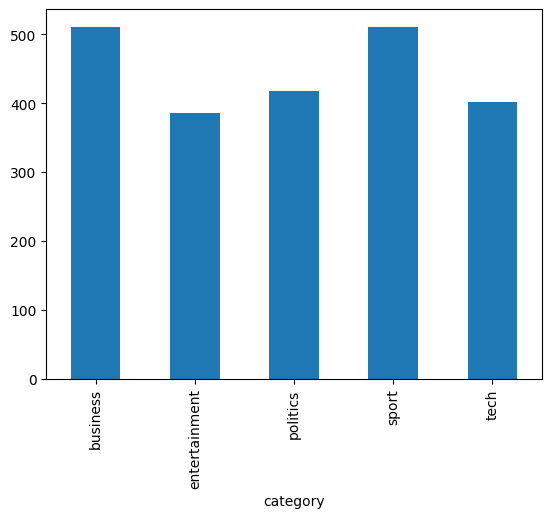

In [34]:
df.groupby(['category']).size().plot.bar()

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [36]:
import torch
import torch.nn as nn
from transformers import BertModel, AdamW, get_scheduler

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-cased')

        # Enable fine-tuning of BERT layers
        for param in self.bert.parameters():
            param.requires_grad = True  # Allow gradients for BERT layers

        # Add dropout, linear layers, and batch normalization
        self.dropout = nn.Dropout(dropout)  # Tuned dropout rate to 0.3
        self.linear = nn.Linear(768, 5)  # Output layer for 5 classes
        self.bn = nn.BatchNorm1d(5)  # Added batch normalization

    def forward(self, input_id, mask):
        # Get the last hidden state from BERT
        outputs = self.bert(input_ids=input_id, attention_mask=mask, return_dict=True)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, 768)

        # Apply mean pooling to get sentence embeddings
        pooled_output = hidden_states.mean(dim=1)  # Mean pooling instead of CLS token

        # Apply dropout, linear transformation, and batch normalization
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        normalized_output = self.bn(linear_output)  # Normalize outputs

        return normalized_output  # Return raw logits (no activation applied)

# Modifications Summary:
# 1. Fine-tuning enabled by setting `requires_grad=True`.
# 2. Replaced CLS token pooling with mean pooling for better sentence embeddings.
# 3. Tuned dropout rate to 0.3 (from 0.5).
# 4. Added batch normalization after the linear layer.


In [37]:
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import torch.nn as nn
import torch

def train(model, train_data, val_data, learning_rate, epochs):
    # Prepare data
    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Scheduler for learning rate decay
    num_training_steps = len(train_dataloader) * epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    accumulation_steps = 4  # Define accumulation steps

    for epoch_num in range(epochs):
        # Training phase
        model.train()
        total_acc_train = 0
        total_loss_train = 0

        optimizer.zero_grad()  # Initialize gradients before epoch

        for i, (train_input, train_label) in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch_num + 1}")):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            # Forward pass
            output = model(input_id, mask)
            batch_loss = criterion(output, train_label.long())
            batch_loss = batch_loss / accumulation_steps  # Scale loss by accumulation steps
            batch_loss.backward()  # Backpropagate

            # Track metrics
            total_loss_train += batch_loss.item() * accumulation_steps
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Accumulate gradients
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
                optimizer.step()
                scheduler.step()  # Update learning rate
                optimizer.zero_grad()  # Clear gradients for next accumulation

        # Validation phase
        model.eval()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in tqdm(val_dataloader, desc=f"Validation Epoch {epoch_num + 1}"):
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Print epoch summary
        print(f"Epoch {epoch_num + 1}/{epochs}")
        print(f"Train Loss: {total_loss_train / len(train_data):.3f}, Train Accuracy: {total_acc_train / len(train_data):.3f}")
        print(f"Val Loss: {total_loss_val / len(val_data):.3f}, Val Accuracy: {total_acc_val / len(val_data):.3f}")


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            preds = output.argmax(dim=1)

            # Collect predictions and labels for evaluation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())

            acc = (preds == test_label).sum().item()
            total_acc_test += acc

    # Calculate accuracy
    accuracy = total_acc_test / len(test_data)
    print(f'Test Accuracy: {accuracy:.3f}')

    # Generate classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


In [39]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [40]:
EPOCHS = 5
model = BertClassifier()
LR = 2e-6

train(model, df_train, df_val, LR, EPOCHS)

Validation Epoch 1: 100%|██████████| 111/111 [00:07<00:00, 15.33it/s]


Epoch 1/5
Train Loss: 0.841, Train Accuracy: 0.317
Val Loss: 0.563, Val Accuracy: 0.559


Validation Epoch 2: 100%|██████████| 111/111 [00:07<00:00, 15.38it/s]


Epoch 2/5
Train Loss: 0.721, Train Accuracy: 0.485
Val Loss: 0.458, Val Accuracy: 0.824


Validation Epoch 3: 100%|██████████| 111/111 [00:07<00:00, 15.35it/s]


Epoch 3/5
Train Loss: 0.670, Train Accuracy: 0.517
Val Loss: 0.327, Val Accuracy: 0.865


Validation Epoch 4: 100%|██████████| 111/111 [00:07<00:00, 15.38it/s]


Epoch 4/5
Train Loss: 0.638, Train Accuracy: 0.546
Val Loss: 0.346, Val Accuracy: 0.923


Validation Epoch 5: 100%|██████████| 111/111 [00:07<00:00, 15.39it/s]


Epoch 5/5
Train Loss: 0.629, Train Accuracy: 0.544
Val Loss: 0.323, Val Accuracy: 0.919


In [41]:
evaluate(model, df_test)

Test Accuracy: 0.897

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        57
           1       0.74      0.94      0.83        33
           2       0.98      0.94      0.96        50
           3       0.91      0.78      0.84        40
           4       0.95      0.86      0.90        43

    accuracy                           0.90       223
   macro avg       0.90      0.89      0.89       223
weighted avg       0.91      0.90      0.90       223


Confusion Matrix:
[[54  2  0  1  0]
 [ 1 31  0  0  1]
 [ 1  1 47  0  1]
 [ 1  8  0 31  0]
 [ 3  0  1  2 37]]
